In [2]:
%matplotlib inline

# Single Estimator versus Bagging

Source: http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html

In regression, the expected mean error of an estimator can be decomposed in terms of bias, variance and noise. On average over datasets of the regression problem, the bias term measures the average amount by which the predictions of the estimator differ from predictions of the best possible for the problem. The variance term measures the variability of the predictions of the estimator when it fit over different instances of the problem. Finally, the noise measures the irreducible part of the error which is due to the variability in the data.

The larger the variance, the more sensitive are the prediction for x to small changes in the training set. The bias term corresponds to the difference between the average prediction of the estimator

The tradeoff is beter for bagging: averaging several decision trees fit on bootstrap copies of the dataset slightly increases the bias term but allows for a larger reduction of variance, which results in a lower overall mean squared error.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [7]:
# Settings
n_repeat = 50
n_train = 50
n_test = 1000
noise = 0.1
np.random.seed(0)

estimators = [("Tree", DecisionTreeRegressor()),
             ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

# Generate data
def f(x):
    x = x.ravel()
    
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x-2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)
    
    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))
        
        for i in range(n_repeat):
            y[:,i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))
    return X, y

In [8]:
X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise = noise)
    X_train.append(X)
    y_train.append(y)
    
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


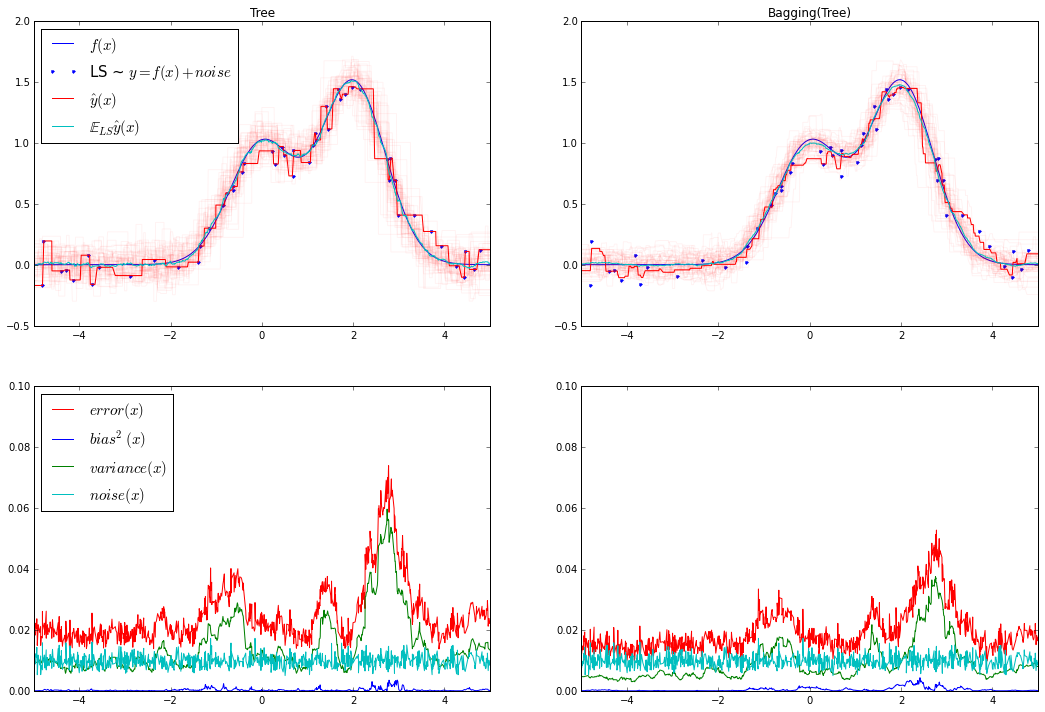

In [18]:
plt.figure(figsize=(18,12))
# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))
    
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:,i] = estimator.predict(X_test)
    
    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)
    
    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:,j] - y_predict[:, i]) ** 2
    
    y_error /= (n_repeat * n_repeat)
    
    y_noise = np.var(y_test, axis = 1)
    y_bias = (f(X_test) - np.mean(y_predict, axis = 1)) ** 2
    y_var = np.var(y_predict, axis = 1)
    
    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))
    
    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")
    
    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)
            
    
    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 15})

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 15})

## Underfitting VS Overfitting

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

/Users/b3j90/anaconda/envs/nlp/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


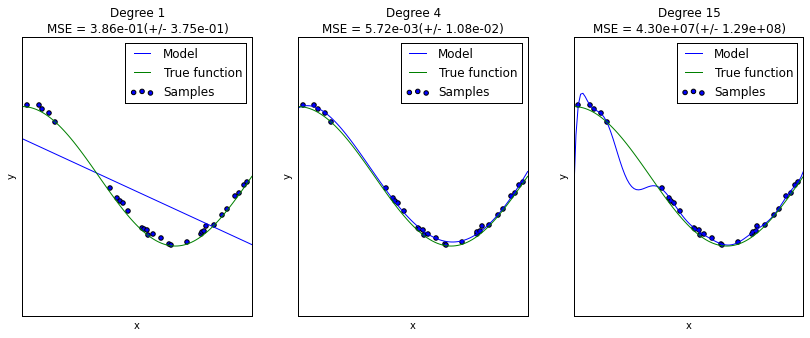

In [26]:
np.random.seed(0)
n_samples = 30
degrees = [1 , 4, 15]

true_func = lambda X: np.cos(1.5 * np.pi *X)
X = np.sort(np.random.rand(n_samples))
y = true_func(X) + np.random.rand(n_samples) * 0.1

plt.figure(figsize=(14,5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i+1)
    plt.setp(ax, xticks=(), yticks=())
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias = False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
              ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis],y)
    
    scores = cross_validation.cross_val_score(pipeline,
            X[:, np.newaxis], y, scoring = "mean_squared_error", cv = 10)
    
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_func(X_test), label="True function")
    plt.scatter(X,y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0,1))
    plt.ylim((-2,2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
    

In [30]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.parasite_axes import host_subplot
from mpl_toolkits.axisartist.axislines import Axes
from scipy.sparse.csr import csr_matrix

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.svm.classes import NuSVR
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.metrics import hamming_loss

Benchmarking SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.25,
       learning_rate='optimal', loss='modified_huber', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Complexity: 4495 | Hamming Loss (Misclassification Ratio): 0.2602 | Pred. Time: 0.025230s

Benchmarking SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.5, learning_rate='optimal',
       loss='modified_huber', n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, verbose=0,
       warm_start=False)
Complexity: 1644 | Hamming Loss (Misclassification Ratio): 0.2889 | Pred. Time: 0.020359s

Benchmarking SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.75,
       learning_rate='optimal'

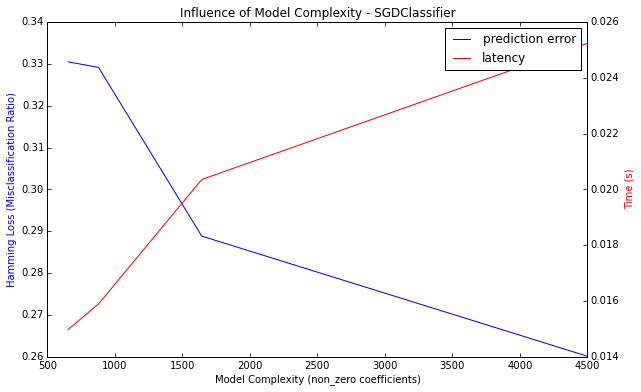

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)
Complexity: 69 | MSE: 31.8133 | Pred. Time: 0.001030s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
   kernel='rbf', max_iter=-1, nu=0.25, shrinking=True, tol=0.001,
   verbose=False)
Complexity: 136 | MSE: 25.6140 | Pred. Time: 0.000778s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)
Complexity: 243 | MSE: 22.3315 | Pred. Time: 0.001805s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
   kernel='rbf', max_iter=-1, nu=0.75, shrinking=True, tol=0.001,
   verbose=False)
Complexity: 350 | MSE: 21.3679 | Pred. Time: 0.001362s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.051757812

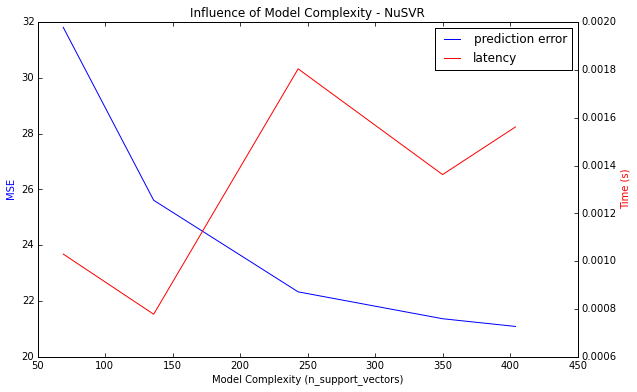

Benchmarking GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)
Complexity: 10 | MSE: 27.9672 | Pred. Time: 0.000402s

Benchmarking GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)
Complexity: 50 | MSE: 8.0288 | Pred. Time: 0.000150s

Benchmarking GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_sam

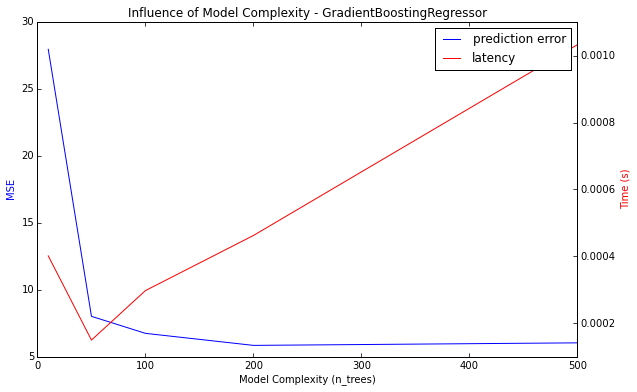

In [32]:
# initialize random generator
np.random.seed(0)


def generate_data(case, sparse=False):
    """Generate regression/classification data."""
    bunch = None
    if case == 'regression':
        bunch = datasets.load_boston()
    elif case == 'classification':
        bunch = datasets.fetch_20newsgroups_vectorized(subset='all')
    X, y = shuffle(bunch.data, bunch.target)
    offset = int(X.shape[0] * 0.8)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    if sparse:
        X_train = csr_matrix(X_train)
        X_test = csr_matrix(X_test)
    else:
        X_train = np.array(X_train)
        X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_train = np.array(y_train)
    data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train,
            'y_test': y_test}
    return data


def benchmark_influence(conf):
    """
    Benchmark influence of :changing_param: on both MSE and latency.
    """
    prediction_times = []
    prediction_powers = []
    complexities = []
    for param_value in conf['changing_param_values']:
        conf['tuned_params'][conf['changing_param']] = param_value
        estimator = conf['estimator'](**conf['tuned_params'])
        print("Benchmarking %s" % estimator)
        estimator.fit(conf['data']['X_train'], conf['data']['y_train'])
        conf['postfit_hook'](estimator)
        complexity = conf['complexity_computer'](estimator)
        complexities.append(complexity)
        start_time = time.time()
        for _ in range(conf['n_samples']):
            y_pred = estimator.predict(conf['data']['X_test'])
        elapsed_time = (time.time() - start_time) / float(conf['n_samples'])
        prediction_times.append(elapsed_time)
        pred_score = conf['prediction_performance_computer'](
            conf['data']['y_test'], y_pred)
        prediction_powers.append(pred_score)
        print("Complexity: %d | %s: %.4f | Pred. Time: %fs\n" % (
            complexity, conf['prediction_performance_label'], pred_score,
            elapsed_time))
    return prediction_powers, prediction_times, complexities


def plot_influence(conf, mse_values, prediction_times, complexities):
    """
    Plot influence of model complexity on both accuracy and latency.
    """
    plt.figure(figsize=(12, 6))
    host = host_subplot(111, axes_class=Axes)
    plt.subplots_adjust(right=0.75)
    par1 = host.twinx()
    host.set_xlabel('Model Complexity (%s)' % conf['complexity_label'])
    y1_label = conf['prediction_performance_label']
    y2_label = "Time (s)"
    host.set_ylabel(y1_label)
    par1.set_ylabel(y2_label)
    p1, = host.plot(complexities, mse_values, 'b-', label="prediction error")
    p2, = par1.plot(complexities, prediction_times, 'r-',
                    label="latency")
    host.legend(loc='upper right')
    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    plt.title('Influence of Model Complexity - %s' % conf['estimator'].__name__)
    plt.show()


def _count_nonzero_coefficients(estimator):
    a = estimator.coef_.toarray()
    return np.count_nonzero(a)

###############################################################################
# main code
regression_data = generate_data('regression')
classification_data = generate_data('classification', sparse=True)
configurations = [
    {'estimator': SGDClassifier,
     'tuned_params': {'penalty': 'elasticnet', 'alpha': 0.001, 'loss':
                      'modified_huber', 'fit_intercept': True},
     'changing_param': 'l1_ratio',
     'changing_param_values': [0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'non_zero coefficients',
     'complexity_computer': _count_nonzero_coefficients,
     'prediction_performance_computer': hamming_loss,
     'prediction_performance_label': 'Hamming Loss (Misclassification Ratio)',
     'postfit_hook': lambda x: x.sparsify(),
     'data': classification_data,
     'n_samples': 30},
    {'estimator': NuSVR,
     'tuned_params': {'C': 1e3, 'gamma': 2 ** -15},
     'changing_param': 'nu',
     'changing_param_values': [0.1, 0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'n_support_vectors',
     'complexity_computer': lambda x: len(x.support_vectors_),
     'data': regression_data,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
    {'estimator': GradientBoostingRegressor,
     'tuned_params': {'loss': 'ls'},
     'changing_param': 'n_estimators',
     'changing_param_values': [10, 50, 100, 200, 500],
     'complexity_label': 'n_trees',
     'complexity_computer': lambda x: x.n_estimators,
     'data': regression_data,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
]
for conf in configurations:
    prediction_performances, prediction_times, complexities = \
        benchmark_influence(conf)
    plot_influence(conf, prediction_performances, prediction_times,
                   complexities)

The main factors that influence the **prediction latency** are:
1. Number of features
2. Input data representation and sparsity
3. Model complexity
4. Feature extraction